In [1]:
!pip install alibi-detect

     ---------------------------------------- 0.0/43.5 kB ? eta -:--:--
     ---------------------------------------- 43.5/43.5 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/381.5 kB ? eta -:--:--
   ---------------------------------------- 381.5/381.5 kB 7.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.8 MB ? eta -:--:--
    --------------------------------------- 0.6/38.8 MB 11.8 MB/s eta 0:00:04
   - -------------------------------------- 1.0/38.8 MB 11.1 MB/s eta 0:00:04
   - -------------------------------------- 1.6/38.8 MB 12.7 MB/s eta 0:00:03
   -- ------------------------------------- 2.1/38.8 MB 12.1 MB/s eta 0:00:04
   -- ------------------------------------- 2.7/38.8 MB 12.4 MB/s eta 0:00:03
   --- ------------------------------------ 3.2/38.8 MB 12.2 MB/s eta 0:00:03
   --- ------------------------------------ 3.8/38.8 MB 12.2 MB/s eta 0:00:03
   ---- ----------------------------------- 4.3/38.8 MB 12.0 MB/s eta 0:00:03
   

**Step 10: Model Monitoring - Data Drift Analysis**

In this step, we'll perform data drift analysis to check if the distribution of the production data has significantly shifted compared to the training data. We'll use the Kolmogorov-Smirnov (K-S) test to detect drift in the numerical features.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from alibi_detect.cd import KSDrift

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# Class: DriftDetector

## Purpose
The `DriftDetector` class is designed to:
- Compare a training dataset (reference data) with a production dataset (current data) to detect **data drift**.
- Use statistical tests (**K-S test**) to identify features with significant distribution changes.
- Visualize the drift results to aid in understanding which features are affected.

---

## Attributes

### `url_train`
- URL pointing to the **training dataset** stored in Parquet format.  
- This dataset serves as the baseline (reference) for drift detection.

### `url_prod`
- URL pointing to the **production dataset** stored in Parquet format.  
- This dataset contains the new data to be compared against the training dataset.

### `X_train`
- DataFrame to store the **training dataset** after loading.

### `X_prod`
- DataFrame to store the **production dataset** after loading and preprocessing.

### `cd`
- Instance of the **`KSDrift`** drift detection model from `alibi-detect`.  
- Initialized with the training dataset and used to perform drift detection.


In [5]:
class DriftDetector:
    """
    A class to handle drift detection using the KSDrift method.
    """

    def __init__(self, url_train, url_prod):
        """
        Initializes the DriftDetector with training and production data URLs.

        Parameters:
        - url_train (str): URL to the training dataset.
        - url_prod (str): URL to the production dataset.
        """
        self.url_train = url_train
        self.url_prod = url_prod
        self.X_train = None
        self.X_prod = None
        self.cd = None

    def load_data(self):
        """
        Loads the training and production datasets from the provided URLs.
        """
        self.X_train = pd.read_parquet(self.url_train)
        self.X_prod = pd.read_parquet(self.url_prod)

    def preprocess_data(self):
        """
        Preprocesses the production data by casting integer columns to float64.
        """
        integer_columns = self.X_prod.select_dtypes(include=['int64']).columns
        self.X_prod[integer_columns] = self.X_prod[integer_columns].astype(float)

    def initialize_drift_detector(self, p_val=0.05):
        """
        Initializes the KSDrift detector with the training data.

        Parameters:
        - p_val (float): p-value threshold for drift detection. Default is 0.05.
        """
        self.cd = KSDrift(self.X_train.values, p_val=p_val)

    def detect_drift(self):
        """
        Performs drift detection on the production data and displays results.
        """
        if self.cd is None:
            raise ValueError("Drift detector is not initialized. Call initialize_drift_detector() first.")
        
        preds = self.cd.predict(self.X_prod.values)

        # Store results for analysis
        results = []
        for f in range(self.cd.n_features):
            fname = self.X_train.columns[f]
            stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
            results.append((fname, stat_val, p_val))
            print(f'{fname} -- K-S {stat_val:.3f} -- p-value {p_val:.3f}')

        return results

    def analyze_drift(self, results):
        """
        Analyzes and visualizes drift detection results.

        Parameters:
        - results (list): List of tuples containing feature name, statistic value, and p-value.
        """
        features, stat_values, p_values = zip(*results)

        # Plot K-S statistic values
        plt.figure(figsize=(10, 5))
        plt.bar(features, stat_values, color='blue', alpha=0.7)
        plt.axhline(0.05, color='red', linestyle='--', label='Threshold (0.05)')
        plt.title('K-S Statistic Values per Feature')
        plt.xlabel('Features')
        plt.ylabel('K-S Statistic')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Plot p-values
        plt.figure(figsize=(10, 5))
        plt.bar(features, p_values, color='green', alpha=0.7)
        plt.axhline(0.05, color='red', linestyle='--', label='Threshold (0.05)')
        plt.title('P-Values per Feature')
        plt.xlabel('Features')
        plt.ylabel('P-Value')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

CustomerID -- K-S 0.042 -- p-value 0.205
num_purchases -- K-S 0.014 -- p-value 0.999
total_quantity -- K-S 0.019 -- p-value 0.972
avg_quantity -- K-S 0.016 -- p-value 0.995
std_quantity -- K-S nan -- p-value nan
total_amount -- K-S 0.029 -- p-value 0.617
avg_transaction -- K-S 0.060 -- p-value 0.019
std_transaction -- K-S nan -- p-value nan
avg_unit_price -- K-S 0.056 -- p-value 0.031
std_unit_price -- K-S nan -- p-value nan
country -- K-S 0.015 -- p-value 0.997


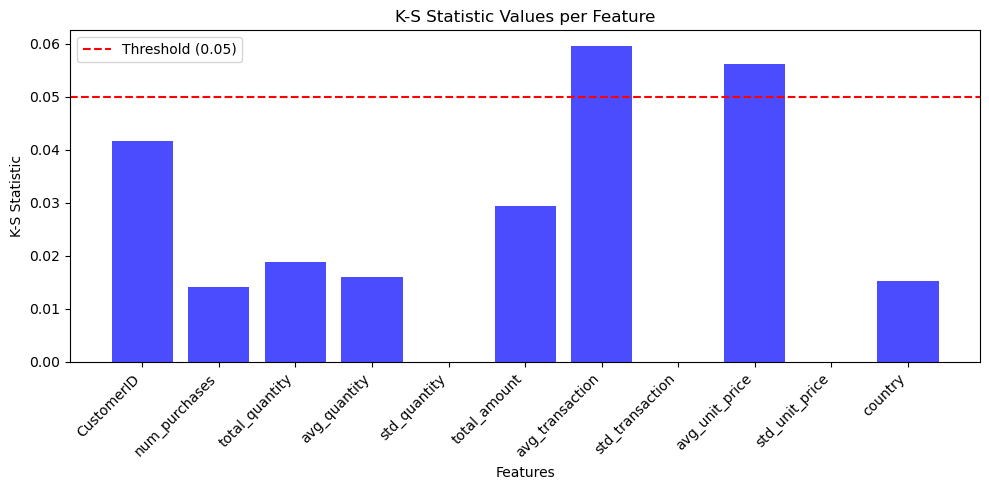

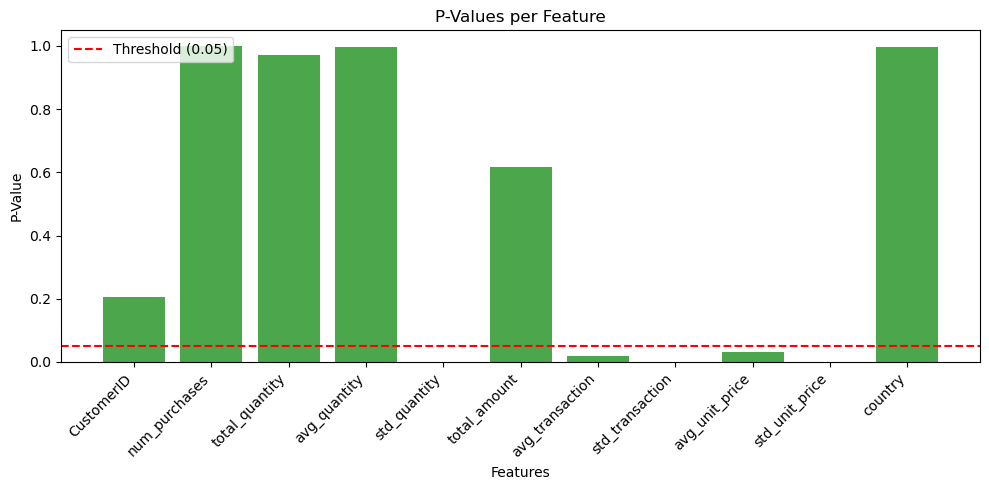

In [6]:

# URLs for the datasets
URL_TRAIN = "https://raw.githubusercontent.com/Group8MLUL2/Group8_CT1/main/processed/train_data.parquet"
URL_PROD = "https://raw.githubusercontent.com/Group8MLUL2/Group8_CT1/main/processed/prod_data.parquet"

# Initialize the DriftDetector
drift_detector = DriftDetector(URL_TRAIN, URL_PROD)

# Load and preprocess the data
drift_detector.load_data()
drift_detector.preprocess_data()

# Initialize the drift detector and perform drift detection
drift_detector.initialize_drift_detector(p_val=0.05)
results = drift_detector.detect_drift()

# Analyze and visualize the results
drift_detector.analyze_drift(results)


## Key Insights
- **`std_transaction`** and **`std_unit_price`** are flagged in both charts, indicating significant changes and requiring further investigation.  
- Features like **`country`** and **`total_quantity`** appear stable and consistent over time.
